In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
from PIL import Image
import pandas as pd

In [27]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)
def linear_function(x, m, b):
    return m * x + b
def FindRoot(m,b):
    return -b/m
def brightness_distribution_along_axis(image, axis):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sum pixel values along the specified axis
    brightness_distribution = 1 / np.sum(img_gray, axis=axis)

    return brightness_distribution

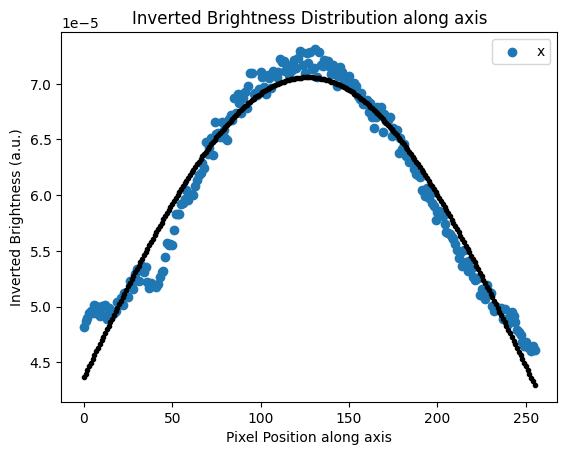

In [31]:
# Load an image (replace 'your_image.jpg' with the actual image file)
image = cv2.imread('frame1.png')
if image is None:
    print("Error: Could not read the image.")
    exit()

x_dim, y_dim,_ = image.shape
x=np.arange(0,x_dim,1)
    
# Calculate brightness distribution along the x-axis
brightness_along_x = brightness_distribution_along_axis(image, axis=0)
brightness_along_y = brightness_distribution_along_axis(image, axis=1)
# Plot the brightness distribution
plt.scatter(x, brightness_along_x, label='x')
plt.title('Inverted Brightness Distribution along axis')
plt.xlabel('Pixel Position along axis')
plt.legend()
plt.ylabel('Inverted Brightness (a.u.)')

fit_params, _ = curve_fit(gaussian, x, brightness_along_x)
plt.plot(x, gaussian(x, *fit_params), 'k.', label=f'Fitted Gaussian')
initial_guess = fit_params

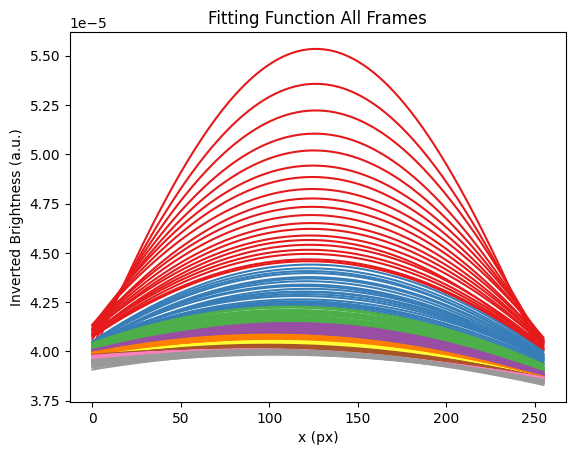

In [55]:
i=0
frame, std, amp = [],[],[]

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Set1(np.linspace(0, 1, 180))))

for i in range(0,180,1):
    image = cv2.imread(f'./decomposed/decomp{i}.tif')
    brightness_along_x = brightness_distribution_along_axis(image, axis=0)
    fit_params, _ = curve_fit(gaussian, x, brightness_along_x)
    plt.plot(x, gaussian(x, *fit_params), label=f'Fitted Gaussian {i}')
    amplitude, mean, stddev = fit_params
    plt.title('Fitting Function All Frames')
    plt.xlabel('x (px)')
    plt.ylabel('Inverted Brightness (a.u.)')
    
    frame.append(i)
    std.append(stddev)
    amp.append(amplitude)

    i += 1
plt.show()
indices = np.array(frame)
sigma = np.array(std)
A = np.array(amp)

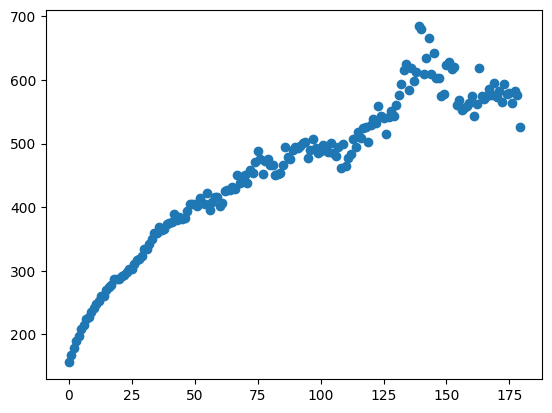

In [56]:
fitting_range=[0,180]
sigma = sigma[fitting_range[0]:fitting_range[1]]
indices = indices[fitting_range[0]:fitting_range[1]]
plt.scatter(indices, sigma)

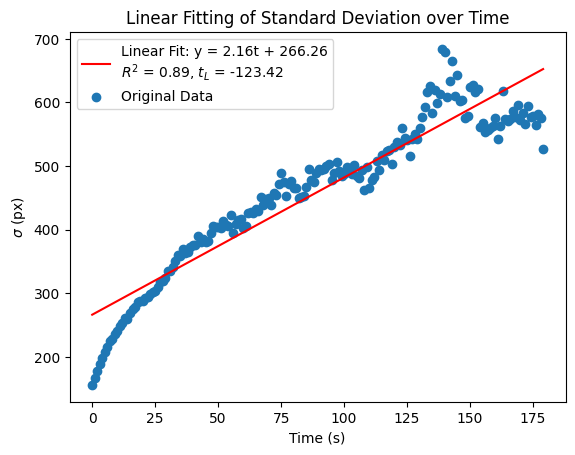

In [57]:
params, covariance = curve_fit(linear_function, indices, sigma)
m, b = params
y_fit = linear_function(indices, m, b)
residuals = sigma - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((sigma - np.mean(sigma))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.scatter(indices, sigma, label='Original Data')
plt.plot(indices, y_fit, label=f'Linear Fit: y = {m:.2f}t + {b:.2f}\n$R^2$ = {r_squared:.2f}, $t_L$ = {FindRoot(m,b):.2f}', color='red')
plt.legend()
plt.xlabel('Time (s)')
plt.gca().set_ylabel(r'$\sigma$ (px)')
plt.title('Linear Fitting of Standard Deviation over Time')
plt.show()

/var/folders/r7/3f8k14kd1yq3rnjcn0yy7nbm0000gn/T/ipykernel_72222/336342999.py:1: RuntimeWarning: divide by zero encountered in log
  log_indices = np.log(indices)


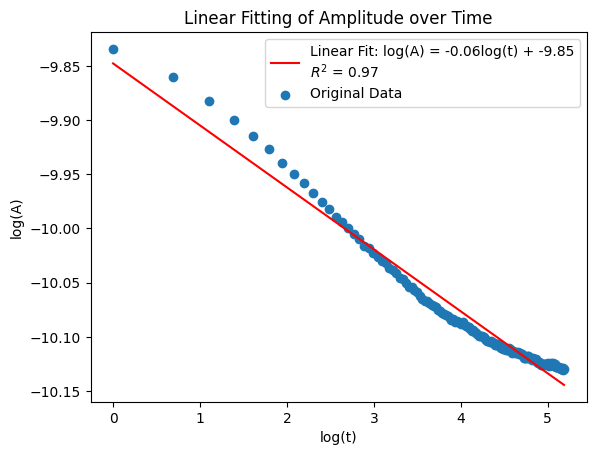

In [38]:
log_indices = np.log(indices)
log_A = np.log(A)
nan_indices = np.isinf(log_indices)
log_indices = log_indices[~nan_indices]
log_A = log_A[~nan_indices]
params, covariance = curve_fit(linear_function, log_indices, log_A)
m, b = params
y_fit = linear_function(log_indices, m, b)
residuals = log_A - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((log_A - np.mean(log_A))**2)
r_squared = 1 - (ss_res / ss_tot)
plt.scatter(log_indices, log_A, label='Original Data')
plt.plot(log_indices, y_fit, label=f'Linear Fit: log(A) = {m:.2f}log(t) + {b:.2f}\n$R^2$ = {r_squared:.2f}', color='red')
plt.legend()
plt.xlabel('log(t)')
plt.ylabel('log(A)')
plt.title('Linear Fitting of Amplitude over Time')
plt.show()